<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-and-Metric" data-toc-modified-id="Exploratory-Data-Analysis-and-Metric-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploratory Data Analysis and Metric</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Submit" data-toc-modified-id="Submit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submit</a></span></li><li><span><a href="#Homework" data-toc-modified-id="Homework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Homework</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Часть-1.-(4-балла)" data-toc-modified-id="Часть-1.-(4-балла)-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Часть 1. (4 балла)</a></span></li><li><span><a href="#Часть-2.-(3-баллов)" data-toc-modified-id="Часть-2.-(3-баллов)-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Часть 2. (3 баллов)</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter
import razdel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
import nltk
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils.class_weight import compute_class_weight

In [2]:
SEED = 42

In [3]:
DATA_PATH = './data'

**[Kaggle InClass: Language Detection](https://www.kaggle.com/t/6b23f7b92b4b497e9aead739dd00ae1a)**

# Exploratory Data Analysis and Metric

In [4]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')

In [5]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [6]:
train_df['language'].unique()

array(['fr', 'cs', 'sv', 'ar', 'hr', 'id', 'az', 'ru', 'he', 'ja', 'de',
       'nl', 'zh-tw', 'ko', 'it', 'hu', 'en', 'fa', 'vi', 'bg', 'th',
       'zh-cn', 'ku', 'tr', 'el', 'nb', 'es', 'pl', 'et', 'ro', 'sr',
       'da', 'uk', 'pt-br', 'ka', 'ta', 'zh', 'sl', 'sk', 'lt', 'my',
       'mn', 'fr-ca', 'mk', 'fi', 'sq', 'pt', 'eu', 'hy', 'hi', 'gl',
       'bn', 'mr', 'bs', 'be', 'ms', 'eo', 'ur', 'kk'], dtype=object)

In [7]:
# в разметке есть ошибки 

train_df[train_df['language'] == 'ru'].head()

,sentence,language
10,После увольнения я решил собрать своих друзей ...,ru
13,"Ты знаешь , что это не гнев заставил моё сердц...",ru
26,гэта што калі мы не яны як але ён каб дзякуй б...,ru
40,"Ради всех имён , которые я никогда не узнаю , ...",ru
91,що це тому ми чи дуже які щоб дякую якщо було ...,ru


In [8]:
train_df.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
train_df.shape, test_df.shape

((2741628, 2), (2784634, 2))

In [10]:
train_df.drop(train_df[train_df['sentence'].str.len() <= 5].index, inplace=True)

In [11]:
train_df.shape, test_df.shape

((2738485, 2), (2784634, 2))

In [12]:
train_df.head(15)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [13]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count['index'][0:10].values

array(['en', 'ar', 'he', 'ru', 'ko', 'it', 'ja', 'zh-tw', 'zh-cn', 'es'],
      dtype=object)

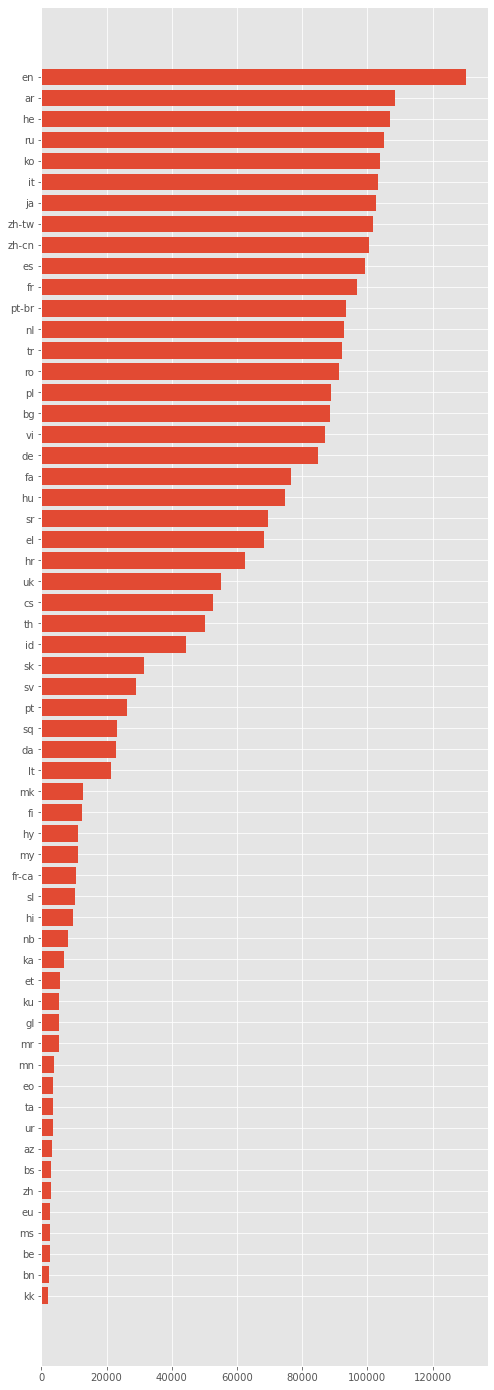

In [14]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [15]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
0,en,130390
58,kk,2012


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$

Веса выбирались обратно пропорционально количеству примеров соответствующего языка:
$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$
$$ \dots $$
$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать [sklearn.metrics.balanced_accuracy_score](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

In [16]:
tokens_counter = {}
tokens = {}

for lan in tqdm(train_df['language'].unique()):
    tokens_counter[lan] = Counter()
    tokens[lan] = []
    temp_lan = train_df[train_df['language'] == lan]
    for s in temp_lan.sentence:
        t = razdel.tokenize(s.lower())
        mtokens = [token.text for token in t]
        tokens[lan].append(mtokens)
        for token in mtokens:
            tokens_counter[lan][token] += 1

100%|██████████| 59/59 [11:14<00:00, 11.44s/it]


In [17]:
# посмотреть, какие символы / токены встречаются во всех языках

m = set(tokens_counter['ru'].keys())

for lan in tokens_counter:
    m &= set(tokens_counter[lan].keys())
    
m

{'%',
 '&',
 '(',
 ')',
 ',',
 '-',
 '.',
 '...',
 ':',
 ';',
 '?',
 'apos',
 'quot',
 'ted',
 '—'}

In [18]:
def lan_cooccurence(data, stop_words):
    cooccurence = Counter()

    for s in data:
        s = [token for token in s if token not in stop_words]
        for i in range(len(s) - 1):
            cooccurence[(s[i], s[i + 1])] += 1

    return cooccurence.most_common(10)

In [19]:
# коллокации для русского, английского и итальянского языков

marks = set([',', '.','?',':', '-', '%', '&', '(', ')', '#', ';', '*', '..', '...', '+', '€', '™', '_', '«', '—', '»', '!', '–', '♫', '$', 'quot', 'apos'])

In [20]:
stopword_set_rus = set(nltk.corpus.stopwords.words('russian'))
stopword_set_rus |= marks
stopword_set_rus |= set({'это', 'который', 'весь', 'наш', 'свой', 'ещё', 'её', 'ваш', 'также', 'итак'})

lan_cooccurence(tokens['ru'], stopword_set_rus)

[(('самом', 'деле'), 1206),
 (('лет', 'назад'), 701),
 (('таким', 'образом'), 589),
 (('нам', 'нужно'), 418),
 (('всему', 'миру'), 341),
 (('друг', 'друга'), 270),
 (('точки', 'зрения'), 263),
 (('тех', 'пор'), 247),
 (('каждый', 'день'), 240),
 (('сих', 'пор'), 231)]

In [21]:
stopword_set_en = set(nltk.corpus.stopwords.words('english'))
stopword_set_en |= marks

lan_cooccurence(tokens['en'], stopword_set_en)

[(('years', 'ago'), 950),
 (('little', 'bit'), 706),
 (('united', 'states'), 511),
 (('around', 'world'), 433),
 (('new', 'york'), 415),
 (('things', 'like'), 368),
 (('first', 'time'), 340),
 (('every', 'day'), 331),
 (('looks', 'like'), 319),
 (('many', 'people'), 317)]

In [22]:
stopword_set_it = set(nltk.corpus.stopwords.words('italian'))
stopword_set_it |= marks

lan_cooccurence(tokens['it'], stopword_set_it)

[(('anni', 'fa'), 724),
 (('stati', 'uniti'), 548),
 (('maggior', 'parte'), 510),
 (('potete', 'vedere'), 406),
 (('può', 'essere'), 384),
 (('new', 'york'), 340),
 (('prima', 'volta'), 302),
 (('voglio', 'dire'), 298),
 (('potrebbe', 'essere'), 266),
 (('ogni', 'giorno'), 254)]

# Model

In [23]:
vectorizer = CountVectorizer(analyzer='char_wb',
                             ngram_range=(1, 2),
                             preprocessor=lambda x: ''.join([c for c in x if c.isalpha or c == ' ']),
                             max_df=0.8,
                             min_df=30)

In [24]:
x = train_df.values[:,  0]
label_encoder = LabelEncoder().fit(train_df.values[:, 1])
y = label_encoder.transform(train_df.values[:, 1])

keys = np.unique(y)
values = compute_class_weight('balanced', keys, y)

class_weight = {
    keys[i]: values[i] for i in range(keys.shape[0])
}

/Users/ulia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58], y=[17  6  6 ... 26 42 18] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [25]:
pipe = Pipeline([
    ('vectorizer', vectorizer),
    ('model', SGDClassifier(random_state=SEED, loss='log', class_weight=class_weight, verbose=3, n_jobs=-1))
])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [27]:
pipe.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1

-- Epoch 1-- Epoch 1

Norm: 8.69, NNZs: 55595, Bias: -3.129928, T: 1834784, Avg. loss: 0.393164
Total training time: 2.92 seconds.
-- Epoch 2
Norm: 7.91, NNZs: 55595, Bias: -1.559518, T: 1834784, Avg. loss: 0.066430
Total training time: 3.04 seconds.
-- Epoch 2
Norm: 11.11, NNZs: 55595, Bias: -1.822726, T: 1834784, Avg. loss: 0.144116
Total training time: 3.05 seconds.
-- Epoch 2
Norm: 6.02, NNZs: 55595, Bias: -1.050858, T: 1834784, Avg. loss: 0.006093
Total training time: 3.07 seconds.
-- Epoch 2
Norm: 7.64, NNZs: 55595, Bias: -1.606714, T: 3669568, Avg. loss: 0.008141
Total training time: 4.62 seconds.
-- Epoch 3
Norm: 6.58, NNZs: 55595, Bias: -3.147794, T: 3669568, Avg. loss: 0.001279
Total training time: 4.54 seconds.
-- Epoch 3
Norm: 7.55, NNZs: 55595, Bias: -1.862278, T: 3669568, Avg. loss: 0.001452
Total training time: 4.64 seconds.
-- Epoch 3
Norm: 5.95, NNZs: 55595, Bias: -1.107449, T: 3669568, Avg. loss: 0.002504
Total training time: 4.69 seconds.
-- Epo

Norm: 5.28, NNZs: 55595, Bias: -1.124376, T: 5504352, Avg. loss: 0.001197
Total training time: 5.04 seconds.
-- Epoch 4
Norm: 7.14, NNZs: 55595, Bias: -1.934123, T: 5504352, Avg. loss: 0.009004
Total training time: 5.01 seconds.
-- Epoch 4
Norm: 6.82, NNZs: 55595, Bias: -2.277267, T: 7339136, Avg. loss: 0.005758
Total training time: 6.59 seconds.
-- Epoch 5
Norm: 8.79, NNZs: 55595, Bias: -2.535913, T: 20182624, Avg. loss: 0.024707
Total training time: 18.26 seconds.
-- Epoch 12
Norm: 5.26, NNZs: 55595, Bias: -1.149494, T: 7339136, Avg. loss: 0.001190
Total training time: 6.68 seconds.
-- Epoch 5
Norm: 7.11, NNZs: 55595, Bias: -1.957194, T: 7339136, Avg. loss: 0.008982
Total training time: 6.62 seconds.
-- Epoch 5
Norm: 6.80, NNZs: 55595, Bias: -2.291807, T: 9173920, Avg. loss: 0.005735
Total training time: 8.28 seconds.
-- Epoch 6
Norm: 8.59, NNZs: 55595, Bias: -2.532963, T: 22017408, Avg. loss: 0.023295
Total training time: 19.97 seconds.
-- Epoch 13
Norm: 5.24, NNZs: 55595, Bias: -1.

Norm: 12.01, NNZs: 55595, Bias: -3.786743, T: 5504352, Avg. loss: 0.019546
Total training time: 4.83 seconds.
-- Epoch 4
Norm: 5.94, NNZs: 55595, Bias: -3.456254, T: 11008704, Avg. loss: 0.001715
Total training time: 9.72 seconds.
-- Epoch 7
Norm: 7.86, NNZs: 55595, Bias: -2.216134, T: 11008704, Avg. loss: 0.018431
Total training time: 9.75 seconds.
-- Epoch 7
Norm: 6.09, NNZs: 55595, Bias: -1.385823, T: 12843488, Avg. loss: 0.002721
Total training time: 11.36 seconds.
Convergence after 7 epochs took 11.36 seconds
-- Epoch 1
Norm: 10.61, NNZs: 55595, Bias: -3.757435, T: 7339136, Avg. loss: 0.016671
Total training time: 6.40 seconds.
-- Epoch 5
Norm: 5.93, NNZs: 55595, Bias: -3.459328, T: 12843488, Avg. loss: 0.001712
Total training time: 11.35 seconds.
Convergence after 7 epochs took 11.35 seconds
-- Epoch 1
Norm: 7.84, NNZs: 55595, Bias: -2.221039, T: 12843488, Avg. loss: 0.018437
Total training time: 11.40 seconds.
-- Epoch 8
Norm: 24.82, NNZs: 55595, Bias: -2.152816, T: 1834784, Avg

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.3min


Norm: 6.98, NNZs: 55595, Bias: -2.216381, T: 14678272, Avg. loss: 0.032204
Total training time: 13.16 seconds.
-- Epoch 9
Norm: 6.39, NNZs: 55595, Bias: -2.088327, T: 11008704, Avg. loss: 0.009593
Total training time: 9.81 seconds.
-- Epoch 7
Norm: 7.85, NNZs: 55595, Bias: -2.094285, T: 1834784, Avg. loss: 0.126034
Total training time: 1.61 seconds.
-- Epoch 2
Norm: 5.71, NNZs: 55595, Bias: -0.819498, T: 1834784, Avg. loss: 0.002533
Total training time: 1.59 seconds.
-- Epoch 2
Norm: 6.96, NNZs: 55595, Bias: -2.216380, T: 16513056, Avg. loss: 0.032097
Total training time: 14.88 seconds.
Convergence after 9 epochs took 14.89 seconds
Norm: 6.37, NNZs: 55595, Bias: -2.093968, T: 12843488, Avg. loss: 0.009509
Total training time: 11.41 seconds.
Convergence after 7 epochs took 11.41 seconds
-- Epoch 1
-- Epoch 1
Norm: 5.68, NNZs: 55595, Bias: -0.867358, T: 3669568, Avg. loss: 0.001901
Total training time: 3.21 seconds.
-- Epoch 3
Norm: 7.70, NNZs: 55595, Bias: -2.142735, T: 3669568, Avg. lo

Norm: 25.34, NNZs: 55595, Bias: -4.334183, T: 3669568, Avg. loss: 0.138213
Total training time: 3.46 seconds.
-- Epoch 3
Norm: 5.68, NNZs: 55595, Bias: -1.428183, T: 7339136, Avg. loss: 0.001153
Total training time: 6.76 seconds.
-- Epoch 5
Norm: 5.93, NNZs: 55595, Bias: -2.014967, T: 5504352, Avg. loss: 0.001276
Total training time: 5.17 seconds.
-- Epoch 4
Norm: 5.03, NNZs: 55595, Bias: -1.363206, T: 3669568, Avg. loss: 0.000969
Total training time: 3.48 seconds.
-- Epoch 3
Norm: 19.40, NNZs: 55595, Bias: -4.319129, T: 5504352, Avg. loss: 0.073181
Total training time: 5.07 seconds.
-- Epoch 4
Norm: 5.63, NNZs: 55595, Bias: -1.445877, T: 9173920, Avg. loss: 0.001142
Total training time: 8.42 seconds.
-- Epoch 6
Norm: 5.88, NNZs: 55595, Bias: -2.028217, T: 7339136, Avg. loss: 0.001260
Total training time: 6.83 seconds.
-- Epoch 5
Norm: 4.99, NNZs: 55595, Bias: -1.396716, T: 5504352, Avg. loss: 0.000967
Total training time: 5.06 seconds.
-- Epoch 4
Norm: 16.13, NNZs: 55595, Bias: -4.302

Norm: 7.61, NNZs: 55595, Bias: -1.768322, T: 9173920, Avg. loss: 0.029838
Total training time: 9.82 seconds.
-- Epoch 6
Norm: 6.98, NNZs: 55595, Bias: -2.306490, T: 9173920, Avg. loss: 0.037632
Total training time: 9.62 seconds.
-- Epoch 6
Norm: 7.05, NNZs: 55595, Bias: -2.012879, T: 7339136, Avg. loss: 0.006511
Total training time: 6.74 seconds.
-- Epoch 5
Norm: 7.56, NNZs: 55595, Bias: -1.568737, T: 1834784, Avg. loss: 0.065178
Total training time: 1.61 seconds.
-- Epoch 2
Norm: 7.50, NNZs: 55595, Bias: -1.770430, T: 11008704, Avg. loss: 0.028912
Total training time: 11.36 seconds.
-- Epoch 7
Norm: 6.95, NNZs: 55595, Bias: -2.307803, T: 11008704, Avg. loss: 0.037198
Total training time: 11.23 seconds.
-- Epoch 7
Norm: 7.03, NNZs: 55595, Bias: -2.029641, T: 9173920, Avg. loss: 0.006497
Total training time: 8.32 seconds.
-- Epoch 6
Norm: 7.41, NNZs: 55595, Bias: -1.617309, T: 3669568, Avg. loss: 0.008368
Total training time: 3.22 seconds.
-- Epoch 3
Norm: 7.45, NNZs: 55595, Bias: -1.77

Norm: 5.27, NNZs: 55595, Bias: -1.154260, T: 9173920, Avg. loss: 0.000992
Total training time: 8.26 seconds.
-- Epoch 6
Norm: 7.40, NNZs: 55595, Bias: -2.076665, T: 11008704, Avg. loss: 0.004498
Total training time: 9.77 seconds.
-- Epoch 7
Norm: 7.06, NNZs: 55595, Bias: -1.857959, T: 1834784, Avg. loss: 0.039978
Total training time: 1.67 seconds.
-- Epoch 2
Norm: 5.10, NNZs: 55595, Bias: -1.171487, T: 9173920, Avg. loss: 0.001051
Total training time: 8.35 seconds.
-- Epoch 6
Norm: 5.26, NNZs: 55595, Bias: -1.170269, T: 11008704, Avg. loss: 0.000992
Total training time: 9.91 seconds.
-- Epoch 7
Norm: 7.39, NNZs: 55595, Bias: -2.086416, T: 12843488, Avg. loss: 0.004498
Total training time: 11.41 seconds.
Convergence after 7 epochs took 11.41 seconds
-- Epoch 1
Norm: 6.93, NNZs: 55595, Bias: -1.909124, T: 3669568, Avg. loss: 0.005619
Total training time: 3.36 seconds.
-- Epoch 3
Norm: 5.09, NNZs: 55595, Bias: -1.186620, T: 11008704, Avg. loss: 0.001046
Total training time: 10.02 seconds.

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  3.2min finished


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer='char_wb', max_df=0.8, min_df=30,
                                 ngram_range=(1, 2),
                                 preprocessor=<function <lambda> at 0x7fc06ecfdf70>)),
                ('model',
                 SGDClassifier(class_weight={0: 0.4276224871478322,
                                             1: 13.752592592592592,
                                             2: 18.273622047244096,
                                             3: 0.5247300887456899,
                                             4: 19.404264214046822,
                                             5: 15.379390324718356,
                                             6: 0.8814257771700944,
                                             7: 2.02173534...
                                             16: 3.688413858868404,
                                             17: 0.4788951826745494,
                                             18: 4.3

In [28]:
labels = label_encoder.transform(list(lang_count['index'][0:10].values))
labels

array([10,  0, 20, 44, 30, 26, 27, 58, 57, 12])

<Figure size 3600x8640 with 0 Axes>

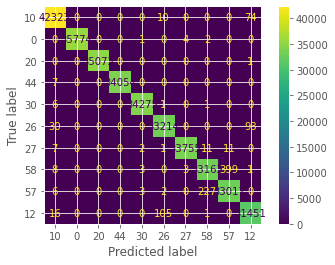

In [29]:
plt.figure()

plot_confusion_matrix(pipe, X_test, y_test, labels=labels)
plt.show()

In [30]:
pipe.fit(x, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1



Norm: 7.54, NNZs: 69158, Bias: -1.993800, T: 2738485, Avg. loss: 0.057608
Total training time: 4.88 seconds.
-- Epoch 2
Norm: 7.62, NNZs: 69158, Bias: -1.491313, T: 2738485, Avg. loss: 0.084378
Total training time: 4.93 seconds.
-- Epoch 2
Norm: 6.01, NNZs: 69158, Bias: -1.053651, T: 2738485, Avg. loss: 0.008321
Total training time: 4.96 seconds.
-- Epoch 2
Norm: 7.74, NNZs: 69158, Bias: -1.950712, T: 2738485, Avg. loss: 0.125436
Total training time: 4.92 seconds.
-- Epoch 2
Norm: 7.38, NNZs: 69158, Bias: -2.026066, T: 5476970, Avg. loss: 0.008099
Total training time: 7.92 seconds.
-- Epoch 3
Norm: 6.80, NNZs: 69158, Bias: -1.540705, T: 5476970, Avg. loss: 0.001683
Total training time: 7.95 seconds.
-- Epoch 3
Norm: 5.95, NNZs: 69158, Bias: -1.110087, T: 5476970, Avg. loss: 0.002486
Total training time: 8.02 seconds.
-- Epoch 3
Norm: 6.78, NNZs: 69158, Bias: -1.994388, T: 5476970, Avg. loss: 0.001742
Total training time: 7.98 seconds.
-- Epoc

Norm: 7.04, NNZs: 69158, Bias: -2.099101, T: 8215455, Avg. loss: 0.008927
Total training time: 12.11 seconds.
-- Epoch 4
Norm: 6.71, NNZs: 69158, Bias: -2.448932, T: 13692425, Avg. loss: 0.005720
Total training time: 21.49 seconds.
-- Epoch 6
Norm: 5.18, NNZs: 69158, Bias: -1.224924, T: 10953940, Avg. loss: 0.001172
Total training time: 15.18 seconds.
-- Epoch 5
Norm: 7.51, NNZs: 69158, Bias: -3.192245, T: 30123335, Avg. loss: 0.020065
Total training time: 45.99 seconds.
-- Epoch 12
Norm: 7.01, NNZs: 69158, Bias: -2.119840, T: 10953940, Avg. loss: 0.008927
Total training time: 14.88 seconds.
-- Epoch 5
Norm: 5.16, NNZs: 69158, Bias: -1.243643, T: 13692425, Avg. loss: 0.001162
Total training time: 17.76 seconds.
-- Epoch 6
Norm: 6.70, NNZs: 69158, Bias: -2.459704, T: 16430910, Avg. loss: 0.005722
Total training time: 24.23 seconds.
-- Epoch 7
Norm: 7.00, NNZs: 69158, Bias: -2.136052, T: 13692425, Avg. loss: 0.008902
Total training time: 17.52 seconds.
-- Epoch 6
Norm: 7.39, NNZs: 69158,

Norm: 5.96, NNZs: 69158, Bias: -1.541131, T: 19169395, Avg. loss: 0.002657
Total training time: 21.93 seconds.
Convergence after 7 epochs took 21.93 seconds
-- Epoch 1
Norm: 9.39, NNZs: 69158, Bias: -2.357598, T: 10953940, Avg. loss: 0.014461
Total training time: 11.83 seconds.
-- Epoch 5
Norm: 5.88, NNZs: 69158, Bias: -3.632544, T: 19169395, Avg. loss: 0.001695
Total training time: 21.95 seconds.
Convergence after 7 epochs took 21.95 seconds
-- Epoch 1
Norm: 7.86, NNZs: 69158, Bias: -2.039859, T: 16430910, Avg. loss: 0.018285
Total training time: 19.44 seconds.
-- Epoch 7
Norm: 18.79, NNZs: 69158, Bias: -2.120400, T: 2738485, Avg. loss: 0.389067
Total training time: 2.69 seconds.
-- Epoch 2
Norm: 8.99, NNZs: 69158, Bias: -2.354899, T: 13692425, Avg. loss: 0.013857
Total training time: 14.60 seconds.
-- Epoch 6
Norm: 5.26, NNZs: 69158, Bias: -1.193693, T: 2738485, Avg. loss: 0.001378
Total training time: 2.72 seconds.
-- Epoch 2
Norm: 7.84, NNZs: 69158, Bias: -2.046588, T: 19169395, Av

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min


Norm: 4.93, NNZs: 69158, Bias: -1.419268, T: 16430910, Avg. loss: 0.000900
Total training time: 18.87 seconds.
Convergence after 6 epochs took 18.87 seconds
-- Epoch 1
Norm: 7.82, NNZs: 69158, Bias: -2.038233, T: 2738485, Avg. loss: 0.072423
Total training time: 2.89 seconds.
-- Epoch 2
Norm: 6.49, NNZs: 69158, Bias: -1.940191, T: 16430910, Avg. loss: 0.009579
Total training time: 18.89 seconds.
-- Epoch 7
Norm: 5.66, NNZs: 69158, Bias: -0.895033, T: 2738485, Avg. loss: 0.001999
Total training time: 2.83 seconds.
-- Epoch 2
Norm: 5.52, NNZs: 69158, Bias: -0.899225, T: 2738485, Avg. loss: 0.001122
Total training time: 2.86 seconds.
-- Epoch 2
Norm: 7.69, NNZs: 69158, Bias: -2.089205, T: 5476970, Avg. loss: 0.009407
Total training time: 5.67 seconds.
-- Epoch 3
Norm: 6.47, NNZs: 69158, Bias: -1.946493, T: 19169395, Avg. loss: 0.009530
Total training time: 21.84 seconds.
Convergence after 7 epochs took 21.84 seconds
-- Epoch 1
Norm: 5.62, NNZs: 69158, Bias: -0.940455, T: 5476970, Avg. los

Norm: 6.07, NNZs: 69158, Bias: -1.616474, T: 8215455, Avg. loss: 0.001376
Total training time: 11.29 seconds.
-- Epoch 4
Norm: 15.25, NNZs: 69158, Bias: -5.552118, T: 8215455, Avg. loss: 0.047546
Total training time: 11.70 seconds.
-- Epoch 4
Norm: 5.40, NNZs: 69158, Bias: -0.953389, T: 2738485, Avg. loss: 0.001152
Total training time: 4.35 seconds.
-- Epoch 2
Norm: 6.07, NNZs: 69158, Bias: -0.998027, T: 10953940, Avg. loss: 0.001351
Total training time: 15.73 seconds.
-- Epoch 5
Norm: 6.05, NNZs: 69158, Bias: -1.633524, T: 10953940, Avg. loss: 0.001368
Total training time: 15.99 seconds.
-- Epoch 5
Norm: 12.92, NNZs: 69158, Bias: -5.513563, T: 10953940, Avg. loss: 0.031347
Total training time: 16.10 seconds.
-- Epoch 5
Norm: 6.04, NNZs: 69158, Bias: -1.019200, T: 13692425, Avg. loss: 0.001345
Total training time: 19.97 seconds.
-- Epoch 6
Norm: 5.33, NNZs: 69158, Bias: -1.019681, T: 5476970, Avg. loss: 0.001100
Total training time: 8.64 seconds.
-- Epoch 3
Norm: 6.03, NNZs: 69158, Bia

Norm: 7.16, NNZs: 69158, Bias: -1.800047, T: 13692425, Avg. loss: 0.006619
Total training time: 20.17 seconds.
-- Epoch 6
Norm: 7.23, NNZs: 69158, Bias: -1.963619, T: 16430910, Avg. loss: 0.027572
Total training time: 24.77 seconds.
-- Epoch 7
Norm: 7.26, NNZs: 69158, Bias: -1.776093, T: 10953940, Avg. loss: 0.008435
Total training time: 15.41 seconds.
-- Epoch 5
Norm: 6.95, NNZs: 69158, Bias: -2.178977, T: 16430910, Avg. loss: 0.036567
Total training time: 23.88 seconds.
-- Epoch 7
Norm: 7.15, NNZs: 69158, Bias: -1.815486, T: 16430910, Avg. loss: 0.006611
Total training time: 23.47 seconds.
-- Epoch 7
Norm: 7.19, NNZs: 69158, Bias: -1.960754, T: 19169395, Avg. loss: 0.027213
Total training time: 27.69 seconds.
-- Epoch 8
Norm: 7.24, NNZs: 69158, Bias: -1.789621, T: 13692425, Avg. loss: 0.008441
Total training time: 18.27 seconds.
-- Epoch 6
Norm: 6.95, NNZs: 69158, Bias: -2.181119, T: 19169395, Avg. loss: 0.036381
Total training time: 26.44 seconds.
-- Epoch 8
Norm: 7.14, NNZs: 69158,

Norm: 6.81, NNZs: 69158, Bias: -2.030097, T: 10953940, Avg. loss: 0.005473
Total training time: 10.17 seconds.
-- Epoch 5
Norm: 5.02, NNZs: 69158, Bias: -1.253652, T: 16430910, Avg. loss: 0.001028
Total training time: 15.36 seconds.
Convergence after 6 epochs took 15.36 seconds
-- Epoch 1
Norm: 7.27, NNZs: 69158, Bias: -1.318862, T: 2738485, Avg. loss: 0.018629
Total training time: 2.50 seconds.
-- Epoch 2
Norm: 6.42, NNZs: 69158, Bias: -0.888775, T: 2738485, Avg. loss: 0.025319
Total training time: 2.44 seconds.
-- Epoch 2
Norm: 6.80, NNZs: 69158, Bias: -2.045168, T: 13692425, Avg. loss: 0.005462
Total training time: 12.68 seconds.
-- Epoch 6
Norm: 5.67, NNZs: 69158, Bias: -1.411828, T: 2738485, Avg. loss: 0.005561
Total training time: 2.50 seconds.
-- Epoch 2
Norm: 7.20, NNZs: 69158, Bias: -1.374284, T: 5476970, Avg. loss: 0.004381
Total training time: 5.00 seconds.
-- Epoch 3
Norm: 6.16, NNZs: 69158, Bias: -0.956694, T: 5476970, Avg. loss: 0.001304
Total training time: 4.98 seconds.

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:  5.9min finished


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer='char_wb', max_df=0.8, min_df=30,
                                 ngram_range=(1, 2),
                                 preprocessor=<function <lambda> at 0x7fc06ecfdf70>)),
                ('model',
                 SGDClassifier(class_weight={0: 0.4276224871478322,
                                             1: 13.752592592592592,
                                             2: 18.273622047244096,
                                             3: 0.5247300887456899,
                                             4: 19.404264214046822,
                                             5: 15.379390324718356,
                                             6: 0.8814257771700944,
                                             7: 2.02173534...
                                             16: 3.688413858868404,
                                             17: 0.4788951826745494,
                                             18: 4.3

# Submit

In [31]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [32]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,ja


In [ ]:
(
    test_df[['index',  'language']]
    .to_csv(f'{DATA_PATH}/submission.csv', index=False)
)

# Homework

### Часть 1. (4 балла)
- исследовать данные
    - почистить обучающую выборку
        - есть ли ошибки в разметке?
    - посмотреть, какие символы / токены встречаются во всех языках
    - выделить коллокации для известных вам языков (хотя бы русский и английский)
- попробовать добавить в модель признаки на основе word2vec или topic modeling
- построить confusion_matrix и посмотреть, какие языки путает модель
- вывести top_k токенов с максимальной важностью для каждого класса
 
### Часть 2. (3 баллов)
- выбить хороший score на private leaderboard'е